<a href="https://colab.research.google.com/github/Neiva07/v4/blob/master/meu_classificador_awgn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/lasseufpa/ml4comm/blob/main/qam_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Globecom Tutorial - December 7, 2021
Tutorial 29: Machine Learning for MIMO Systems with Large Arrays
Nuria Gonzalez-Prelcic (NCSU),
Aldebaro Klautau (UFPA) and
Robert W. Heath Jr. (NCSU)

# QAM classifiers

In [1]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    import sys
    import os
    try:
      !git clone https://github.com/lasseufpa/ml4comm.git
    except:
      print("ml4comm is already in the contents")
    !pip install -r /content/ml4comm/requirements.txt  &>/dev/null
    sys.path.append(os.path.abspath('/content/ml4comm'))

Cloning into 'ml4comm'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 39 (delta 2), reused 36 (delta 2), pack-reused 0
Unpacking objects: 100% (39/39), done.


In [45]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from commpy.channels import SISOFlatChannel

from ml4comm.qam_crazy import crazy_channel_propagate
from ml4comm.qam_awgn import generate_symbols
from ml4comm.qam_analyzer import plot_decision_boundary, ser, plot_confusion_matrix
from ml4comm.classifiers_comparison import train_classifier
 
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Classifiers for QAM demodulation

### Variables

In [76]:
channel_type = 'crazy' # 'awgn' or 'crazy'
M            = 16      # QAM modulation
num_symbols  = 3500    # Number of transmitted symbols
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

### Generate QAM symbols and transmit them over the channel

In [77]:
# Generate the QAM symbols
symbs, indices = generate_symbols(num_symbols, M)

In [78]:
if channel_type == 'awgn':
    channel = SISOFlatChannel(None, (1 + 0j, 0j))
    channel.set_SNR_dB(SNR_dB, float(code_rate), Es)
    channel_output = channel.propagate(symbs)
elif channel_type == 'crazy':
    channel_output = crazy_channel_propagate(symbs, SNR_dB) 
else:
    raise ValueError(f'Channel type {channel_type} not found')

In [79]:
# Generate dataset
# Train
train_size = 500
y_train = indices[:train_size]
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = indices[train_size:]
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

print(train_size, len(indices))
print('X_test',X_test)
print('len X_test',len(X_test))
print('y_test',y_test)
print('y_test',len(y_test))

500 3500
X_test [[-0.75675719  0.39038446]
 [-0.62482996 -0.72489314]
 [ 1.61534932 -1.53649747]
 ...
 [ 0.51770597 -0.53017295]
 [-0.48408989  0.49171262]
 [-0.71426754 -0.58986109]]
len X_test 3000
y_test [ 0  3 10 ... 15  0  3]
y_test 3000


In [80]:
def plot_symbols():
    custom_cmap = cm.get_cmap('tab20')
    num_classes = M
    colors = custom_cmap.colors[:num_classes]
    levels = np.arange(num_classes + 2) - 0.5

    for ii in range(num_classes):
        selected_indices = np.argwhere(y_train==ii)
        selected_indices = selected_indices.reshape((-1))
        plt.plot(X_train[selected_indices, 0], X_train[selected_indices, 1], 'o', color=colors[ii], label=f'{ii}')
        
    plt.plot(np.real(symbs), np.imag(symbs), 'rx')
    plt.legend(title='Classes', bbox_to_anchor=(1, 1), loc='upper left', ncol=2, handleheight=2, labelspacing=0.05, frameon=False)
    plt.ylabel('Quadrature')
    plt.xlabel('In-phase')

    plt.show()  

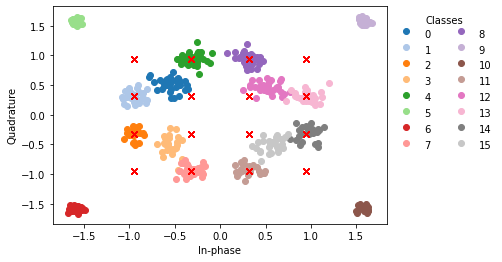

In [81]:
plot_symbols()

## Classifiers

### Decision Tree

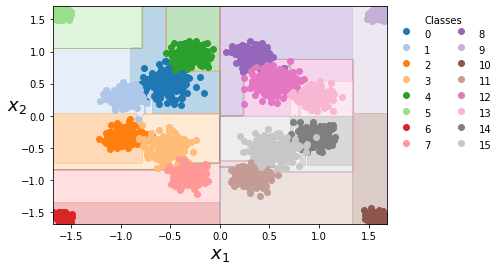

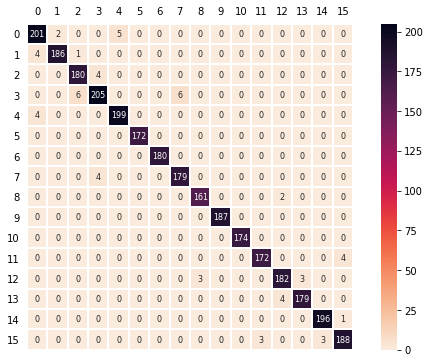

In [ ]:
clf_DT = train_classifier('Decision Tree', X_train, y_train, M)
plot_decision_boundary(clf_DT, X_train, y_train, legend=True)
plot_confusion_matrix(clf_DT, X_test, y_test, M)

In [ ]:
clf_DT_ser = ser(clf_DT, X_test, y_test)
print(f'Decision Tree:\n SER:\t {clf_DT_ser:.2%}')

Decision Tree:
 SER:	 1.97%


### Random Forest

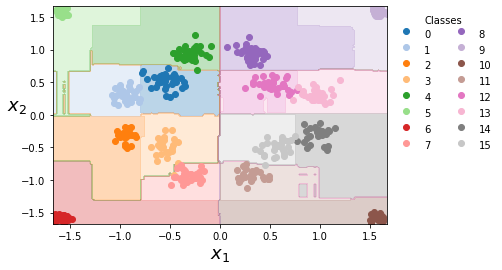

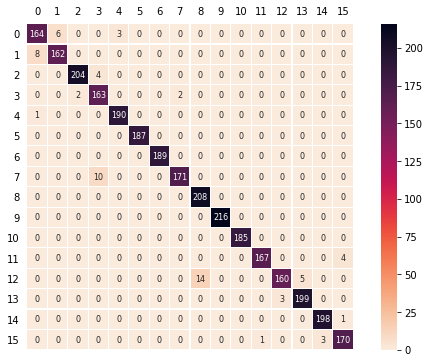

In [82]:
clf_RF = train_classifier('Random Forest', X_train, y_train, M)
plot_decision_boundary(clf_RF, X_train, y_train, legend=True)
plot_confusion_matrix(clf_RF, X_test, y_test, M)

In [85]:
from datetime import datetime

num_executions = 20
time_sum = 0

for _ in range(num_executions):
  start_time = datetime.now()
  clf_RF_ser = ser(clf_RF, X_test, y_test)
  end_time = datetime.now()
  time_sum += (end_time - start_time).total_seconds()
print('time in test: {} milisecs'.format(time_sum*1000/num_executions))
print(f'Random Forest:\n SER:\t {clf_RF_ser:.2%}')

time in test: 21.829299999999996 milisecs
Random Forest:
 SER:	 2.23%


### K-nearest neighbors

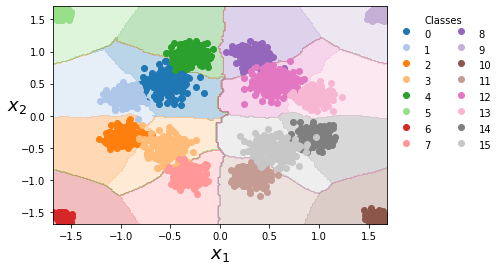

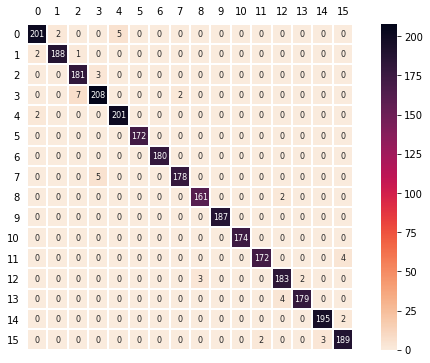

In [ ]:
clf_KNN = train_classifier('Nearest Neighbors', X_train, y_train, M)
plot_decision_boundary(clf_KNN, X_train, y_train, legend=True)
plot_confusion_matrix(clf_KNN, X_test, y_test, M)

In [ ]:
clf_KNN_ser = ser(clf_KNN, X_test, y_test)
print(f'K-nearest neighbors:\n SER:\t {clf_KNN_ser:.2%}')

K-nearest neighbors:
 SER:	 1.70%


### Linear SVM

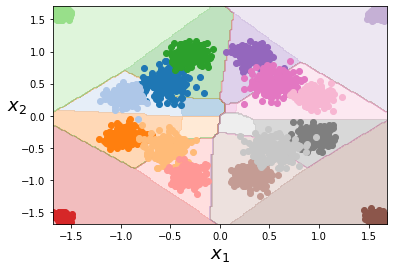

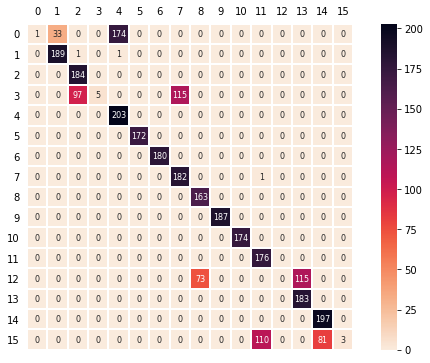

In [ ]:
clf_LSVM = train_classifier('Linear SVM', X_train, y_train, M)
plot_decision_boundary(clf_LSVM, X_train, y_train)
plot_confusion_matrix(clf_LSVM, X_test, y_test, M)

In [ ]:
clf_LSVM_ser = ser(clf_LSVM, X_test, y_test)
print(f'Linear SVM:\n SER:\t {clf_LSVM_ser:.2%}')

Linear SVM:
 SER:	 26.70%


### SVM with RBF Kernel

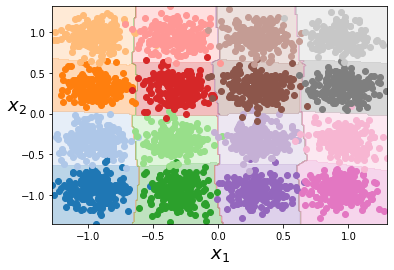

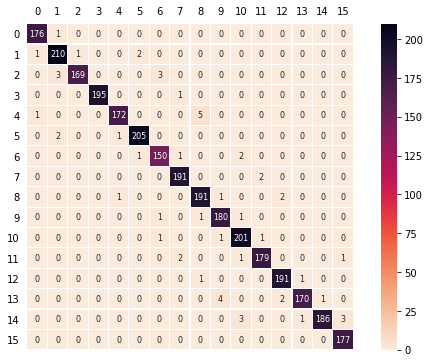

In [53]:
clf_LSVM_RBF = train_classifier('RBF SVM', X_train, y_train, M)
plot_decision_boundary(clf_LSVM_RBF, X_train, y_train)
plot_confusion_matrix(clf_LSVM_RBF, X_test, y_test, M)

In [70]:
from datetime import datetime

num_executions = 20

time_sum = 0

for _ in range(num_executions):
  start_time = datetime.now()
  clf_LSVM_RBF_ser = ser(clf_LSVM_RBF, X_test, y_test)
  end_time = datetime.now()
  time_sum += (end_time - start_time).total_seconds()
print('time in test: {} milisecs'.format(time_sum*1000/num_executions))
print(f'SVM with RBF kernel:\n SER:\t {clf_LSVM_RBF_ser:.2%}')

time in test: 198.14335000000005 milisecs
SVM with RBF kernel:
 SER:	 1.90%


### MLP

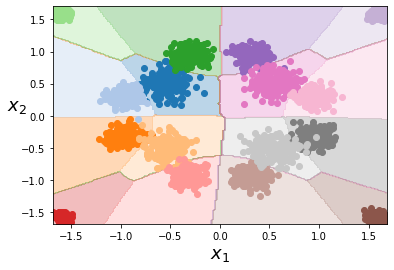

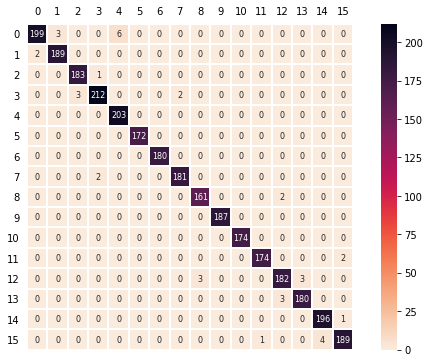

In [ ]:
clf_MLP = train_classifier('Neural Net', X_train, y_train, M)
plot_decision_boundary(clf_MLP, X_train, y_train)
plot_confusion_matrix(clf_MLP, X_test, y_test, M)

In [ ]:
clf_MLP_ser = ser(clf_MLP, X_test, y_test)
print(f'Neural network (MLP):\n SER:\t {clf_MLP_ser:.2%}')

Neural network (MLP):
 SER:	 1.27%


### Naive Bayes

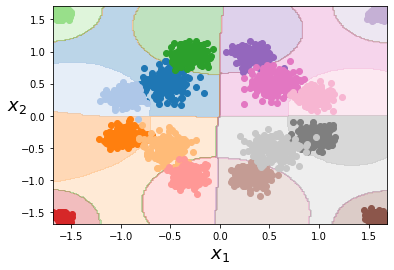

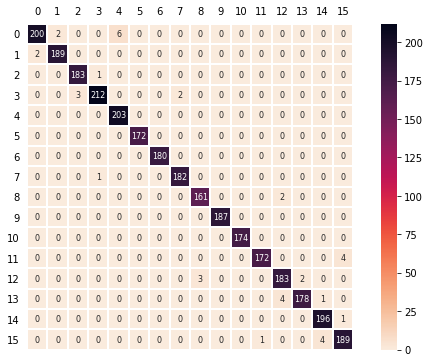

In [ ]:
clf_NB = train_classifier('Naive Bayes', X_train, y_train, M)
plot_decision_boundary(clf_NB, X_train, y_train)
plot_confusion_matrix(clf_NB, X_test, y_test, M)

In [ ]:
clf_NB_ser = ser(clf_MLP, X_test, y_test)
print(f'Naive Bayes:\n SER:\t {clf_NB_ser:.2%}')

Naive Bayes:
 SER:	 1.27%
